Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [43]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\MDA_dataframeArthur.csv")
df_nd = df.drop('result_timestamp', axis=1)

In [3]:
# Drop the datetime column
df_nd = df.drop('result_timestamp', axis=1)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [21]:
y = df_nd["laeq"]
X = df_nd.drop("laeq", axis="columns")

In [22]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [23]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
32951,14,4,19,8,0,52.0,15.73,32.0,437.0,0.0,0.0,-8.0,0.08,373.0,26.25,26.25,26.193,25.146406
32952,14,4,19,8,0,50.0,15.36,32.0,469.0,0.0,0.0,171.0,0.02,230.0,26.53,26.53,26.473,25.640656
32953,14,4,19,8,0,50.0,15.61,31.0,470.0,0.0,0.0,143.0,0.36,228.0,27.05,27.05,26.993,26.296341
32954,14,4,19,8,0,50.0,15.90,32.0,269.0,0.0,0.0,105.0,0.39,297.0,27.31,27.31,27.253,26.501806
32955,14,4,19,8,0,51.0,16.22,31.0,187.0,0.0,0.0,144.0,0.07,397.0,27.32,27.32,27.263,26.213027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42946,2,4,28,10,0,91.0,13.00,38.0,0.0,0.0,0.0,0.0,0.00,0.0,14.39,14.39,14.333,14.198870
42947,2,4,28,10,0,90.0,12.83,37.0,0.0,0.0,0.0,-102.0,0.00,0.0,14.39,14.39,14.333,14.185340
42948,2,4,28,10,0,90.0,12.78,38.0,0.0,0.0,0.0,0.0,0.00,0.0,14.39,14.39,14.333,14.206740
42949,2,4,28,10,0,90.0,12.78,37.0,0.0,0.0,0.0,-92.0,0.04,0.0,14.39,14.39,14.333,14.314940


In [24]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
36951,9,4,16,9,0,84.0,13.90,32.0,163.0,0.0,0.0,59.0,0.03,117.0,16.59,16.59,16.533,16.339917
36952,9,4,16,9,0,82.0,13.60,32.0,210.0,0.0,0.0,-172.0,0.02,127.0,16.78,16.78,16.723,16.384344
36953,9,4,16,9,0,79.0,13.46,31.0,165.0,0.0,0.0,98.0,0.04,134.0,17.07,17.07,17.013,16.527561
36954,9,4,16,9,0,79.0,13.63,32.0,144.0,0.0,0.0,-6.0,0.03,139.0,17.31,17.31,17.253,16.762182
36955,9,4,16,9,0,80.0,14.00,32.0,142.0,0.0,0.0,27.0,0.02,161.0,17.49,17.49,17.433,16.968314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46946,23,3,24,11,0,86.0,6.88,37.0,0.0,0.0,0.0,-81.0,0.12,0.0,9.11,9.11,9.053,9.123540
46947,23,3,24,11,0,86.0,6.92,38.0,0.0,0.0,0.0,26.0,0.03,0.0,9.17,9.17,9.113,9.154146
46948,23,3,24,11,0,85.0,6.81,37.0,0.0,0.0,0.0,36.0,0.21,0.0,9.22,9.22,9.163,9.262167
46949,23,3,24,11,0,85.0,6.78,38.0,0.0,0.0,0.0,78.0,0.13,0.0,9.22,9.22,9.163,9.232913


In [44]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.11,0.12,0.13,0.14,0.15,0.16,0.17),
    'max_leaf_nodes': (13,14,15,16,17,)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.11, 0.12, 0.13, 0.14, 0.15, 0.16,
                                           0.17),
                         'max_leaf_nodes': (13, 14, 15, 16, 17)})

In [45]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.78


In [46]:
model_grid_search.predict(X.iloc[0:5])

array([39.89391601, 40.06524411, 40.06524411, 40.06524411, 40.06524411])

In [47]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.11, 'max_leaf_nodes': 13}


In [48]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.283479,0.081840,0.003196,0.001465,0.11,13,"{'learning_rate': 0.11, 'max_leaf_nodes': 13}",0.647801,0.708140,0.385108,0.642695,-0.158905,0.444968,0.321789,1
1,3.099348,0.173248,0.002802,0.000404,0.11,14,"{'learning_rate': 0.11, 'max_leaf_nodes': 14}",0.641302,0.706818,0.368535,0.644991,-0.159052,0.440519,0.321778,2
3,3.779724,0.225213,0.004189,0.000975,0.11,16,"{'learning_rate': 0.11, 'max_leaf_nodes': 16}",0.647681,0.708127,0.348818,0.640561,-0.158881,0.437261,0.323167,3
2,3.187676,0.126431,0.002592,0.000480,0.11,15,"{'learning_rate': 0.11, 'max_leaf_nodes': 15}",0.640301,0.706818,0.351668,0.644136,-0.158880,0.436809,0.322302,4
4,3.576888,0.242185,0.003598,0.000793,0.11,17,"{'learning_rate': 0.11, 'max_leaf_nodes': 17}",0.641302,0.708025,0.373293,0.643019,-0.184337,0.436261,0.330984,5


In [49]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [50]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.11,13,0.444968,0.321789,1
1,0.11,14,0.440519,0.321778,2
3,0.11,16,0.437261,0.323167,3
2,0.11,15,0.436809,0.322302,4
4,0.11,17,0.436261,0.330984,5
11,0.13,14,0.383729,0.362505,6
19,0.14,17,0.382158,0.366308,7
18,0.14,16,0.381636,0.366003,8
16,0.14,14,0.379931,0.369255,9
23,0.15,16,0.379781,0.363402,10


In [51]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,13,14,15,16,17
param_learning_rate,,,,,
0.11,0.444968,0.440519,0.436809,0.437261,0.436261
0.12,0.360396,0.351985,0.368109,0.356029,0.373087
0.13,0.365180,0.383729,0.374334,0.377119,0.368794
0.14,0.371992,0.379931,0.369641,0.381636,0.382158
0.15,0.359025,0.363029,0.375410,0.379781,0.369573
0.16,0.368744,0.368311,0.361191,0.366474,0.363808
0.17,0.360798,0.366916,0.372396,0.353530,0.369448


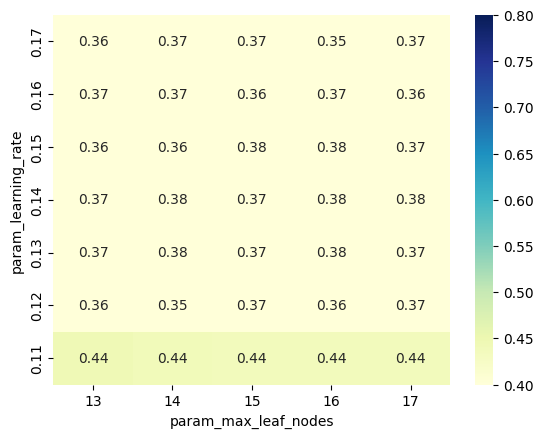

In [52]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [37]:
#run histogram gradient boosting model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=15,learning_rate=0.11)).set_output(transform="pandas")

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.410 +/- 1.255
Root Mean Squared Error: 4.227 +/- 1.268


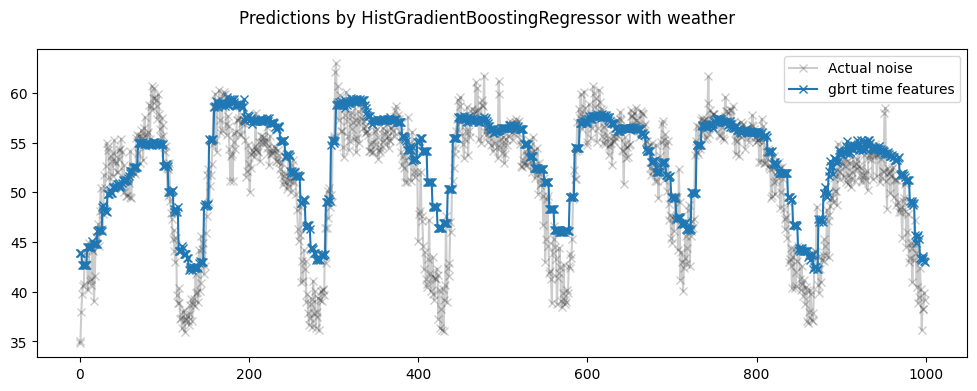

In [38]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


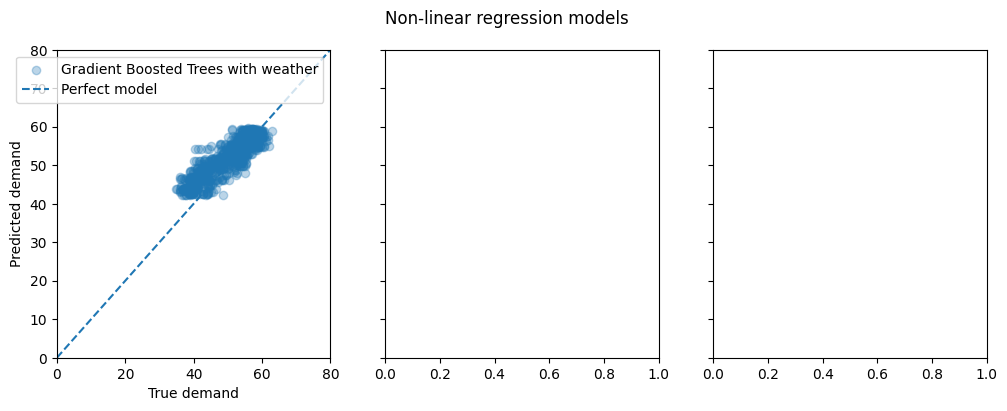

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()